In [1]:

import pandas as pd
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer # 提取词干
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
cols = ['target', 'id', 'date', 'query', 'username', 'content']
df = pd.read_csv("training.csv", engine="python", header=None, names=cols, encoding="latin1")

df.head()

,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.shape

(1600000, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   target    1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   content   1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df.isnull().sum()     # no missing values

target      0
id          0
date        0
query       0
username    0
content     0
dtype: int64

In [6]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

## 数据预处理

将情感标签 4-->1， 0-->0

In [7]:
df['target']=df['target'].replace(4,1) 

在情感分析中无法使用id, date, query及username信息，我可以简单地删除这些列。

In [8]:
df.drop(['id', 'date', 'query', 'username'], axis=1, inplace=True)

In [9]:
df[df['target']==0].head()

,target,content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [10]:
df[df['target']==1].head()

,target,content
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


因此，前80万个查询是negative。而接下来的80万个查询是positive。

### 文本预处理

##### 1.去除停用词
##### 2. 词干提取 + 词形还原
##### 3. 超链接 + @某人

In [11]:
# 停用词
stop_words = stopwords.words("english")

# 词干
stemmer = SnowballStemmer('english')

# 正则化表达式
text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

In [12]:
# 对文本进行清洗
def preprocessing(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token)) # 提取词干
            else:
                tokens.append(token) # 直接保存单词
    return ' '.join(tokens)

In [13]:
# 文本清洗前后对比
print('Before: {}'. format(list(df['content'][:5])))
print('---')
print('After: {}'. format(list(df['content'][:5].apply(preprocessing))))

Before: ["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 'my whole body feels itchy and like its on fire ', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]
---
After: ['awww bummer shoulda got david carr third day', 'upset update facebook texting might cry result school today also blah', 'dived many times ball managed save 50 rest go bounds', 'whole body feels itchy like fire', 'behaving mad see']


In [14]:
df['content'] = df['content'].apply(preprocessing)

df.head()

,target,content
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see


##### 4. 文本词云显示

推特文本内容中有很多元素。有用户名，网址，表情符号，多个点，感叹号和许多其他。我会根据他们的情绪组合所有的推文，并创建他们各自的词云。

In [15]:
positive_tweets = ' '.join(df[df['target'] == 1]['content'].str.lower())
negative_tweets = ' '.join(df[df['target'] == 0]['content'].str.lower())

Text(0.5, 1.0, 'Positive tweets Wordcloud')

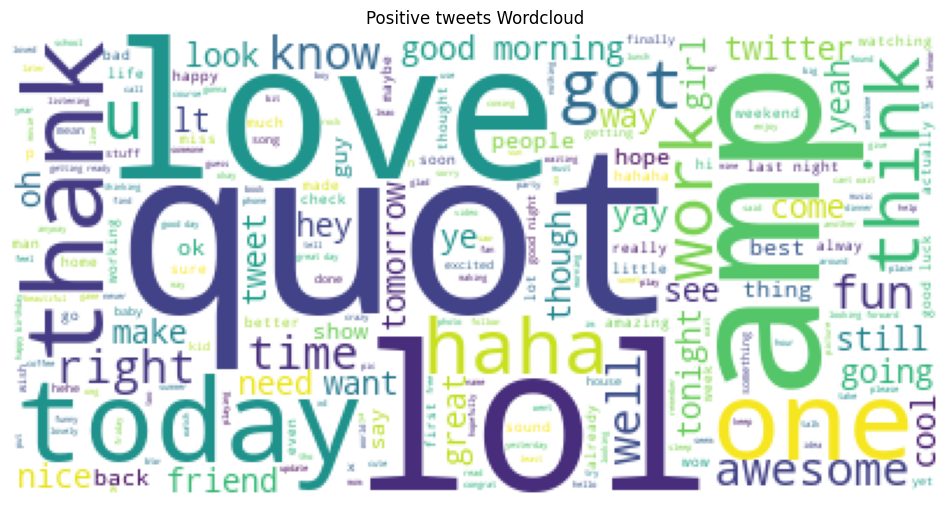

In [16]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = "white", max_words = 1000).generate(positive_tweets)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Positive tweets Wordcloud")

Text(0.5, 1.0, 'Negative tweets Wordcloud')

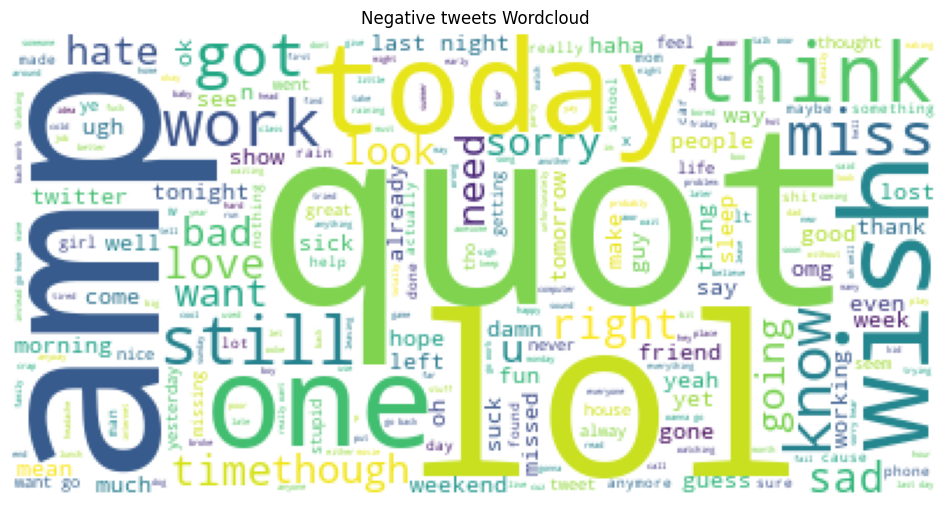

In [17]:
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = "white", max_words = 1000).generate(negative_tweets)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Negative tweets Wordcloud")

从上面的词云来看，似乎每条推文情绪的热门词都非常相似，比如lol和quot。我们将需要创建一个神经网络，即使具有如此高的相似度，也可以对情感进行分类。

##### 5. 分词 + 固定长度 + 编码

In [18]:
# 1.分词

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(df.content)     # 基于文本列表更新内部词汇表

该方法基于词频创建词汇索引。每个单词都得到一个唯一的整数值。0为填充保留。所以较小的整数意味着更频繁的单词(通常前几个是停顿词，因为它们出现得很多)。

In [19]:
# 2.每个单词对应一个索引

word_index = tokenizer.word_index


# 训练集词汇表大小
vocab_size = len(word_index) + 1
vocab_size

335508

In [20]:
# train, test 分离
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_dataset, test_dataset = train_test_split(df, test_size = 0.2, random_state = 666, shuffle=True)

In [21]:
train_dataset.shape

(1280000, 2)

In [22]:
test_dataset.shape

(320000, 2)

在固定文本长度之前，首先看一下正负情感文本长度的分布。

In [39]:
df['length'] = df.content.str.split().apply(len)

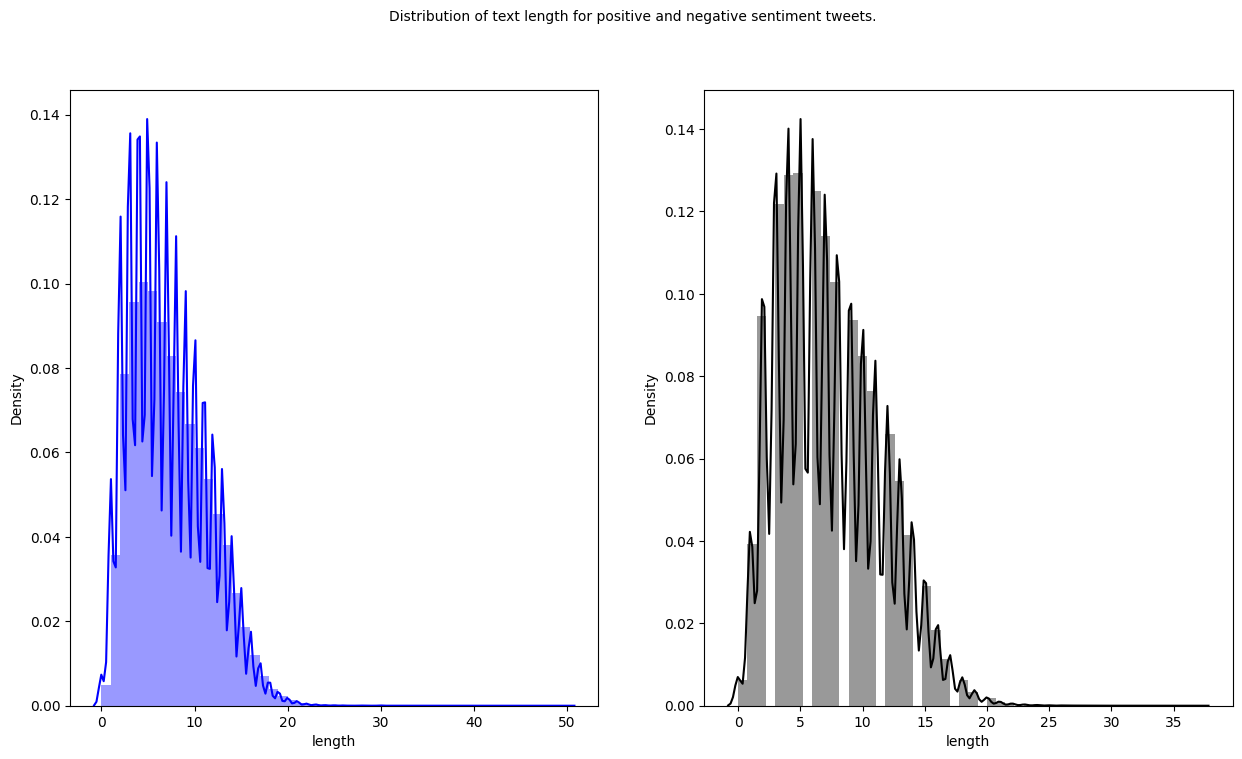

In [40]:
import seaborn as sns

fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(121)
sns.distplot(df[df['target']==1]['length'], ax=ax1,color='blue')
describe = df.length[df.target==1].describe().to_frame().round(2)

ax1 = fig.add_subplot(122)
sns.distplot(df[df['target']==0]['length'], ax=ax1,color='black')
describe = df.length[df.target==0].describe().to_frame().round(2)
fig.suptitle('Distribution of text length for positive and negative sentiment tweets.', fontsize=10)

plt.show()

In [25]:
# 3.固定每一条文本的长度

MAX_WORDS = 100000 # 最大词汇量10万
MAX_SEQ_LENGTH = 30 # 最大序列长度30
from tensorflow.keras.preprocessing.sequence import pad_sequences


x_train = pad_sequences(tokenizer.texts_to_sequences(train_dataset.content),
                        maxlen=MAX_SEQ_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_dataset.content),
                       maxlen=MAX_SEQ_LENGTH)

 texts_to_sequences将文本中的每个文本转换为整数序列。它基本上取文本中的每个单词并用word_index字典中对应的整数值替换它。

In [26]:
x_train.shape

(1280000, 30)

In [27]:
x_test.shape

(320000, 30)

In [28]:
# 4.标签类别进行LabelEncoding，将类别编码成连续的编号

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()


y_train = encoder.fit_transform(train_dataset.target.tolist())

y_test = encoder.fit_transform(test_dataset.target.tolist())

In [29]:
y_train = y_train.reshape(-1, 1) # shape 转置

y_train.shape

(1280000, 1)

In [30]:
y_test = y_test.reshape(-1, 1)

y_test.shape

(320000, 1)

#### 使用Glove进行词嵌入

我们需要将整个GloVe词嵌入文件加载到内存中,作为一个从单词到嵌入数组的字典。

In [31]:
# 5.word embedding 词嵌入 ： 将单词用特征向量来表示，这里使用预训练的词向量 GloVe

GloVe = "glove.6B.300d.txt"

EMBEDDING_DIM = 300 # 300 维

BATCH_SIZE = 10000 # 批处理的大小

EPOCHS = 10 # 循环的次数
 
LR = 1e-3 # 学习率

MODEL_PATH = "best_model.hdf5" # 保存模型路径

In [32]:
# 6.构建字典： 格式： { 单词: 词嵌入向量}

embedding_index = {}

with open(GloVe, encoding='utf-8') as f:
    for line in f:
        values = line.split() # 按空格分割
        word = values[0] # 第一个位置上是单词
        embeddings = np.asarray(values[1:], dtype="float32") # 每个单词对应的词嵌入
        embedding_index[word] = embeddings # 键值对

In [33]:
len(embedding_index) # 单词数

400000

In [34]:
# 7.获取词嵌入矩阵

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM)) # vocab_size : 训练集词汇表大小，EMBEDDING_DIM : 词嵌入维度

num = 0

for word, values in embedding_index.items():
    embedding_vector = embedding_index.get(word) # 单词对应的词嵌入向量
    if embedding_vector is not None:
        if num < vocab_size:
            embedding_matrix[num, :] = embedding_vector
        num += 1

In [35]:
embedding_matrix.shape

(335508, 300)

### 搭建模型

In [74]:
# 预测数据集
valid_data = pd.read_csv('testing.csv', skiprows=1, header=None, names=['date', 'query', 'user', 'text'], encoding='latin-1')

valid_data.head()

,date,query,user,text
0,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


##### 模型1： 基于 CNN + BiLSTM (双向) 的文本分类模型

In [37]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


sequence_input = Input(shape=(MAX_SEQ_LENGTH, ), dtype='int32') # 设置输入序列长度 MAX_SEQ_LENGTH


embedding_layer = Embedding(vocab_size, # 词汇表大小
                            EMBEDDING_DIM, # 词嵌入维度
                            weights = [embedding_matrix], # 预训练词嵌入
                            input_length = MAX_SEQ_LENGTH, # 序列长度
                            trainable = False)


embedding_sequences = embedding_layer(sequence_input)

x = SpatialDropout1D(0.2)(embedding_sequences)
print(x.shape)
x = Conv1D(64, 5, activation='relu')(x)
print(x.shape)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
print(x.shape)
x = Dense(512, activation='relu')(x)
print(x.shape)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
print(x.shape)
outputs = Dense(1, activation='sigmoid')(x)
print(outputs.shape)
model = tf.keras.Model(sequence_input, outputs)

(None, 30, 300)
(None, 26, 64)
(None, 128)
(None, 512)
(None, 512)
(None, 1)


In [41]:
# 模型变异
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

ReduceLR = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)
# factor : 学习速率被降低的因数， 新的学习速率 = 学习率 * 因素
# min_lr : 学习率的下边界
# monitor : 被监测的数据



# 模型训练

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[ReduceLR])

Epoch 1/10
128/128 [==============================] - 414s 3s/step - loss: 0.6348 - accuracy: 0.6304 - val_loss: 0.5735 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 416s 3s/step - loss: 0.5709 - accuracy: 0.6949 - val_loss: 0.5388 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - 417s 3s/step - loss: 0.5474 - accuracy: 0.7147 - val_loss: 0.5198 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 419s 3s/step - loss: 0.5329 - accuracy: 0.7266 - val_loss: 0.5117 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - 417s 3s/step - loss: 0.5236 - accuracy: 0.7342 - val_loss: 0.5036 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - 423s 3s/step - loss: 0.5159 - accuracy: 0.7397 - val_loss: 0.5017 - val_accuracy: 0.7497 - lr: 0.0010
Epoch 7/10
128/128 [==============================] - 428s 3s/st

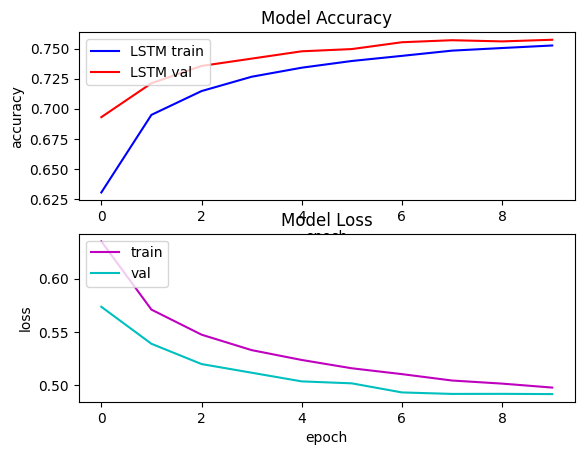

In [42]:
# 绘制训练和验证结果

s, (one, two) = plt.subplots(2, 1)

one.plot(history.history['accuracy'], c='b')
one.plot(history.history['val_accuracy'], c='r')
one.set_title('Model Accuracy')
one.set_ylabel("accuracy")
one.set_xlabel("epoch")
one.legend(['LSTM train', 'LSTM val'], loc='upper left')

two.plot(history.history['loss'], c='m')
two.plot(history.history['val_loss'], c='c')
two.set_title('Model Loss')
two.set_ylabel('loss')
two.set_xlabel('epoch')
two.legend(['train', 'val'], loc='upper left')

In [43]:
# 模型的输出概率在 0 - 1 之间，这里我们设定阈值区分三种情感。

def Judge(score):
    if score > 0.55:
        return 4
    elif score < 0.45:
        return 0
    return 2

In [62]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

y_true = test_dataset.target.replace({0: 0, 1: 4}).tolist()
y_text = pad_sequences(tokenizer.texts_to_sequences(test_dataset.content),
                       maxlen=MAX_SEQ_LENGTH)
scores = model.predict(y_text, verbose=1, batch_size=10000)
y_pred = [Judge(score) for score in scores]


print('accuracy_score', accuracy_score(y_true, y_pred))
print('Micro precision', precision_score(y_true, y_pred, average='micro'))

32/32 [==============================] - 22s 684ms/step
accuracy_score 0.7113375
Micro precision 0.7113375


In [57]:
# 模型在valid上预测

x_valid = pad_sequences(tokenizer.texts_to_sequences(valid_data.text),
                       maxlen=MAX_SEQ_LENGTH)
                       
scores = model.predict(x_valid, verbose=1, batch_size=10000)
valid_data['预测情感极性'] = [Judge(score) for score in scores]

valid_data.columns = ['日期', '关键词', '用户', '留言', '预测情感极性']

valid_data.to_csv('testing_1.csv', index=False)

1/1 [==============================] - 0s 56ms/step


##### 模型2：LSTM 网络 (单个)

In [65]:
from tensorflow.keras import Sequential

model_lstm = Sequential()

# 添加 embedding 层
model_lstm.add(embedding_layer)

# 添加Dropout
model_lstm.add(Dropout(0.5))

# 添加LSTM
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# 添加全连接层
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           100652400 
                                                                 
 dropout_1 (Dropout)         (None, 30, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 100,812,901
Trainable params: 160,501
Non-trainable params: 100,652,400
_________________________________________________________________


In [66]:
# 模型编译

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

history = model_lstm.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         verbose=1,
                         callbacks=EarlyStopping(patience=10, monitor='val_loss'))

Epoch 1/10
128/128 [==============================] - 421s 3s/step - loss: 0.5353 - accuracy: 0.7250 - val_loss: 0.5121 - val_accuracy: 0.7469
Epoch 2/10
128/128 [==============================] - 420s 3s/step - loss: 0.5327 - accuracy: 0.7274 - val_loss: 0.5096 - val_accuracy: 0.7468
Epoch 3/10
128/128 [==============================] - 420s 3s/step - loss: 0.5310 - accuracy: 0.7292 - val_loss: 0.5016 - val_accuracy: 0.7532
Epoch 4/10
128/128 [==============================] - 420s 3s/step - loss: 0.5294 - accuracy: 0.7297 - val_loss: 0.5050 - val_accuracy: 0.7512
Epoch 5/10
128/128 [==============================] - 422s 3s/step - loss: 0.5275 - accuracy: 0.7312 - val_loss: 0.4975 - val_accuracy: 0.7563
Epoch 6/10
128/128 [==============================] - 422s 3s/step - loss: 0.5255 - accuracy: 0.7327 - val_loss: 0.5054 - val_accuracy: 0.7509
Epoch 7/10
128/128 [==============================] - 427s 3s/step - loss: 0.5250 - accuracy: 0.7336 - val_loss: 0.5057 - val_accuracy: 0.7516

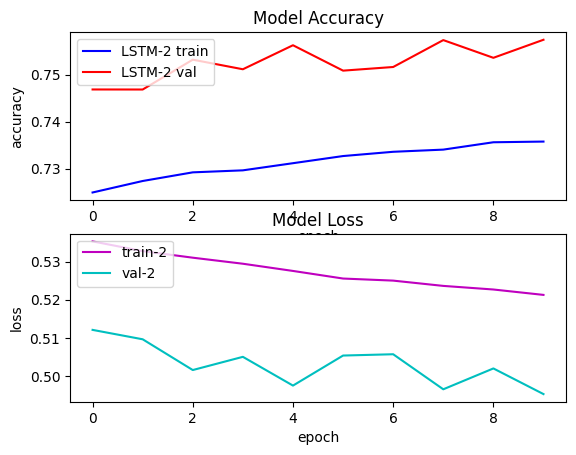

In [69]:
# 绘制训练和验证结果

s, (one, two) = plt.subplots(2, 1)

one.plot(history.history['accuracy'], c='b')
one.plot(history.history['val_accuracy'], c='r')
one.set_title('Model Accuracy')
one.set_ylabel("accuracy")
one.set_xlabel("epoch")
one.legend(['LSTM-2 train', 'LSTM-2 val'], loc='upper left')

two.plot(history.history['loss'], c='m')
two.plot(history.history['val_loss'], c='c')
two.set_title('Model Loss')
two.set_ylabel('loss')
two.set_xlabel('epoch')
two.legend(['train-2', 'val-2'], loc='upper left')

In [72]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

y_true = test_dataset.target.replace({0: 0, 1: 4}).tolist()
y_text = pad_sequences(tokenizer.texts_to_sequences(test_dataset.content),
                       maxlen=MAX_SEQ_LENGTH)
scores = model_lstm.predict(y_text, verbose=1, batch_size=10000)
y_pred = [Judge(score) for score in scores]


print('accuracy_score', accuracy_score(y_true, y_pred))
print('Micro precision', precision_score(y_true, y_pred, average='micro'))

32/32 [==============================] - 23s 703ms/step
accuracy_score 0.717165625
Micro precision 0.717165625


In [75]:
# 模型在valid上预测

x_valid = pad_sequences(tokenizer.texts_to_sequences(valid_data.text),
                       maxlen=MAX_SEQ_LENGTH)
                       
scores = model_lstm.predict(x_valid, verbose=1, batch_size=10000)
valid_data['预测情感极性'] = [Judge(score) for score in scores]

valid_data.columns = ['日期', '关键词', '用户', '留言', '预测情感极性']

valid_data.to_csv('testing_2.csv', index=False)

1/1 [==============================] - 0s 290ms/step


In [ ]:
def predict(text):
    clean_text = clean(text)
    tokenized = [word for word in clean_text.split(' ') if word != '']
    indexed = [TEXT.vocab.stoi[w] for w in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [ ]:
predict("i hate you")